In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


# Backward stepwise
* Backward stepwise selection (or backward elimination) is a variable selection method which:
* Begins with a model that contains all variables under consideration (called the Full Model)
* Then starts removing the least significant variables one after the other
* Until a pre-specified stopping rule is reached or until no variable is left in the model
* From Full model we eliminate the least important features.

# Determine the least significant variable to remove at each step
The least significant variable is a variable that:
* Has the highest p-value in the model, or
* Its elimination from the model causes the lowest drop in R2, or
* Its elimination from the model causes the lowest increase in RSS (Residuals Sum of Squares) compared to other predictors.
# Choose a stopping rule
The stopping rule is satisfied when all remaining variables in the model have a p-value smaller than some pre-specified threshold.
When we reach this state, backward elimination will terminate and return the current step’s model.
# Where backward stepwise is better
* Starting with the full model has the advantage of considering the effects of all variables simultaneously.
* This is especially important in case of collinearity (when variables in a model are correlated which each other) because backward stepwise may be forced to keep them all in the model unlike forward selection where none of them might be entered
* Unless the number of candidate variables > sample size (or number of events), use a backward stepwise approach.

> https://quantifyinghealth.com/stepwise-selection/

# Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import plotting

#plotly 
import plotly.offline as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.express as px

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report,precision_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

In [3]:
df=pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df=df.drop('Unnamed: 32', axis=1)

In [5]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [6]:
diagnosis={'M':1, 'B':0}
df['diagnosis']=[diagnosis[x] for x in df['diagnosis']]

In [7]:
from scipy import stats


In [8]:
r, p=stats.pearsonr(df.radius_mean, df.diagnosis)
print(r)
print(p)

0.7300285113754563
8.465940572259232e-96


In [9]:
cor_df=pd.DataFrame(columns=['r','p-value'])
for col in df:
   # print(col)
    if pd.api.types.is_numeric_dtype(df[col]):
        r, p=stats.pearsonr(df.diagnosis, df[col])
        cor_df.loc[col]=[r, p]
cor_df

,r,p-value
id,0.039769,3.436819e-01
diagnosis,1.000000,0.000000e+00
radius_mean,0.730029,8.465941e-96
texture_mean,0.415185,4.058636e-25
perimeter_mean,0.742636,8.436251e-101
area_mean,0.708984,4.734564e-88
smoothness_mean,0.358560,1.051850e-18
compactness_mean,0.596534,3.938263e-56
concavity_mean,0.696360,9.966556e-84
concave points_mean,0.776614,7.101150e-116


In [10]:
cor_df.sort_values(by=['p-value'], ascending=False)

,r,p-value
symmetry_se,-0.006522,8.766418e-01
texture_se,-0.008303,8.433320e-01
fractal_dimension_mean,-0.012838,7.599368e-01
id,0.039769,3.436819e-01
smoothness_se,-0.067016,1.102966e-01
fractal_dimension_se,0.077972,6.307355e-02
concavity_se,0.253730,8.260176e-10
compactness_se,0.292999,9.975995e-13
fractal_dimension_worst,0.323872,2.316432e-15
symmetry_mean,0.330499,5.733384e-16


In [11]:
col=['symmetry_se', 'texture_se']
X=df.drop(col, axis=1)
y=df['diagnosis']
X_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=10)

# Logistic Regresion

In [12]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
lr=LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [14]:
y_pred=lr.predict(X_train)

In [15]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred))
print("F1 Score:-", metrics.f1_score(y_train, y_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred))
print("Log Loss:-", metrics.log_loss(y_train, y_pred))
print("Precision Score:-", metrics.precision_score(y_train, y_pred))
print("Recall Score:-", metrics.recall_score(y_train, y_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred))

Accuracy Score:- 0.3844221105527638
F1 Score:- 0.5553539019963702
Average Precision Score:- 0.3844221105527638
Log Loss:- 21.261799291767623
Precision Score:- 0.3844221105527638
Recall Score:- 1.0
ROC-AUC Score:- 0.5


In [16]:
y_test_pred=lr.predict(x_test)

In [17]:
lr_acc=metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy Score:-",lr_acc)
print("F1 Score:-", metrics.f1_score(y_test, y_test_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_test, y_test_pred))
print("Log Loss:-", metrics.log_loss(y_test, y_test_pred))
print("Precision Score:-", metrics.precision_score(y_test, y_test_pred))
print("Recall Score:-", metrics.recall_score(y_test, y_test_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy Score:- 0.34502923976608185
F1 Score:- 0.5130434782608695
Average Precision Score:- 0.34502923976608185
Log Loss:- 22.622412345860692
Precision Score:- 0.34502923976608185
Recall Score:- 1.0
ROC-AUC Score:- 0.5


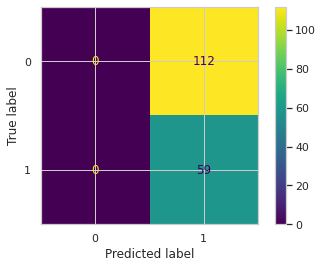

In [18]:
cfm=confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=lr.classes_)
disp.plot() 

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.35      1.00      0.51        59

    accuracy                           0.35       171
   macro avg       0.17      0.50      0.26       171
weighted avg       0.12      0.35      0.18       171



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [20]:
y_test_pred_prob=lr.predict_proba(x_test)[:,1]
y_test_pred_prob

from sklearn.metrics import roc_curve
metrics.roc_auc_score(y_test, y_test_pred_prob)


0.34866828087167073

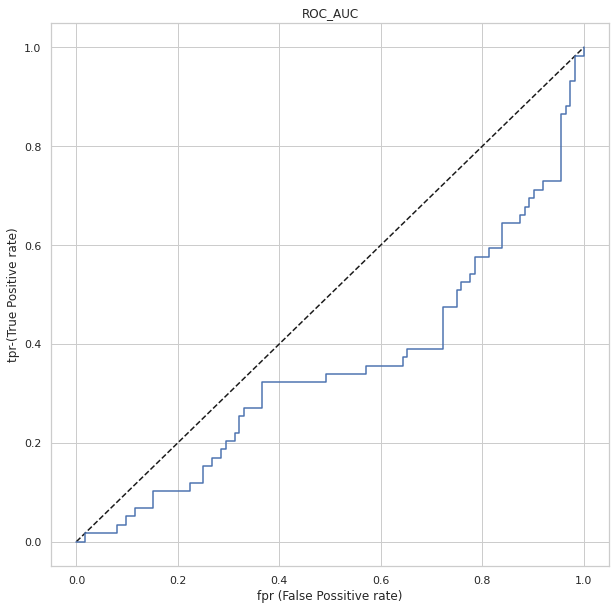

In [21]:
fpr, tpr,thresholds=roc_curve(y_test,y_test_pred_prob)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
plt.title("ROC_AUC")
plt.show()

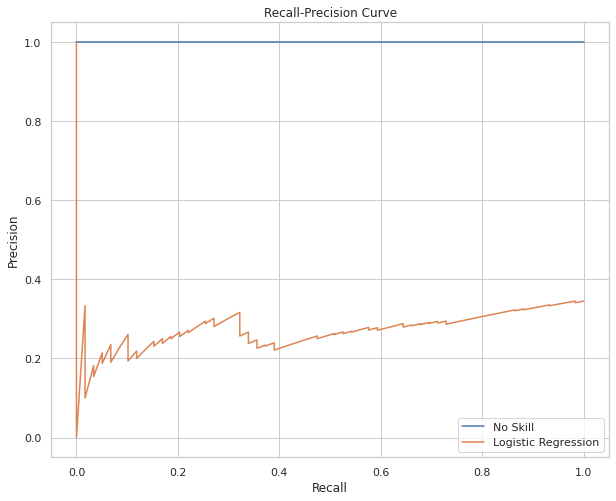

In [22]:
from sklearn.metrics import precision_recall_curve
no_skill=len(y==1)/len(y)
y_test_prob=lr.predict_proba(x_test)[:,1]
plt.figure(figsize=(10,8))
plt.plot([0,1],[no_skill, no_skill], label="No Skill")
precision, recall,_ =precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='',label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision Curve")
plt.legend()
plt.show()

# K-NN

In [23]:
from sklearn.neighbors import KNeighborsClassifier


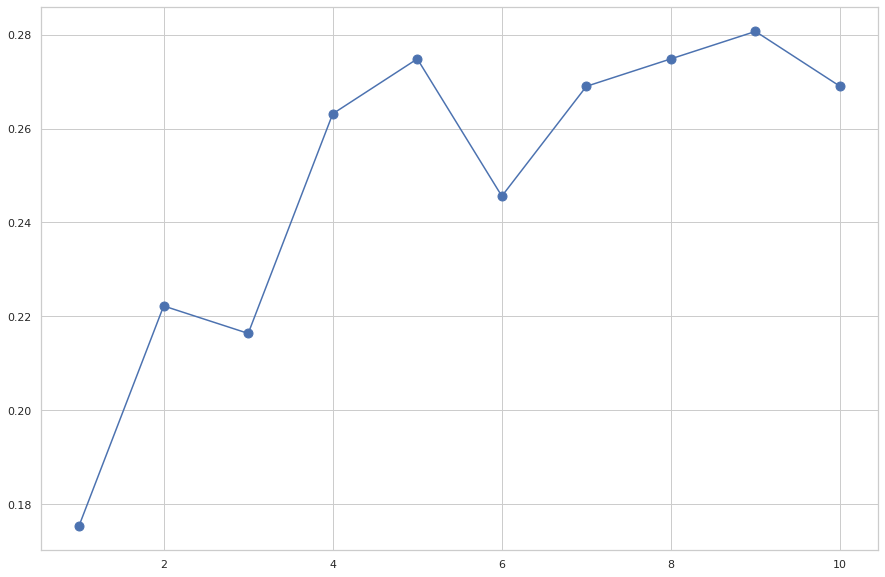

In [24]:
error_rate=[]

for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred=knn.predict(x_test)
    error_rate.append(np.mean(pred!=y_test))
    
plt.figure(figsize=(15,10))
plt.plot(range(1,11), error_rate,marker='o', markersize=9)

# Conclusion:-
As we can see that the optimum K in KNN we get is K=3.

In [25]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [26]:
y_pred=knn.predict(X_train)


In [27]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred))
print("F1 Score:-", metrics.f1_score(y_train, y_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred))
print("Log Loss:-", metrics.log_loss(y_train, y_pred))
print("Precision Score:-", metrics.precision_score(y_train, y_pred))
print("Recall Score:-", metrics.recall_score(y_train, y_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred))

Accuracy Score:- 0.8743718592964824
F1 Score:- 0.8161764705882353
Average Precision Score:- 0.7822453841128529
Log Loss:- 4.339058332977326
Precision Score:- 0.9327731092436975
Recall Score:- 0.7254901960784313
ROC-AUC Score:- 0.8464185674269709


# Conclusion: 
* As we can see that in my previsous notebook the accuracy was 76%, while in this case the accuracy is 87.43%.
* It is observed that removing the two feature help ub increasing the accuracy of the dataset using KNN model as prediction
* Log Loss is decreased as it was 8.482 and now it is 4.33
* ROC-AUC is improved , now it is 0.846 , which is much better than previous results in last notbook

In [28]:
y_test_pred=knn.predict(x_test)

In [29]:
knn_acc=metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy Score:-",knn_acc)
print("F1 Score:-", metrics.f1_score(y_test, y_test_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_test, y_test_pred))
print("Log Loss:-", metrics.log_loss(y_test, y_test_pred))
print("Precision Score:-", metrics.precision_score(y_test, y_test_pred))
print("Recall Score:-", metrics.recall_score(y_test, y_test_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy Score:- 0.783625730994152
F1 Score:- 0.6476190476190476
Average Precision Score:- 0.5721384029959448
Log Loss:- 7.4733586069056
Precision Score:- 0.7391304347826086
Recall Score:- 0.576271186440678
ROC-AUC Score:- 0.7345641646489105


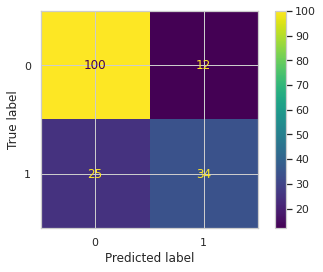

In [30]:
cfm=confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=knn.classes_)
disp.plot() 

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       112
           1       0.74      0.58      0.65        59

    accuracy                           0.78       171
   macro avg       0.77      0.73      0.75       171
weighted avg       0.78      0.78      0.78       171



In [32]:
y_test_pred_prob=knn.predict_proba(x_test)[:,1]
y_test_pred_prob

from sklearn.metrics import roc_curve
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8064467312348667

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

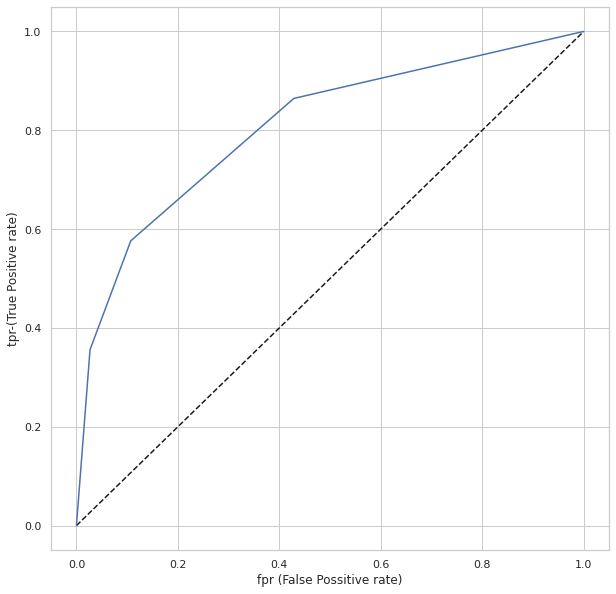

In [33]:
fpr, tpr,thresholds=roc_curve(y_test,y_test_pred_prob)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
plt.title

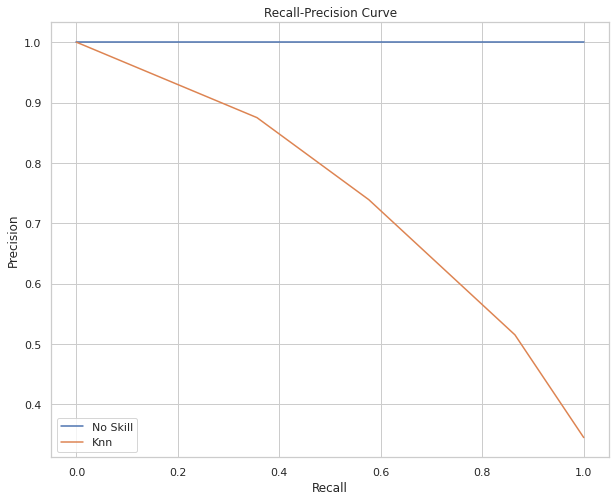

In [34]:
from sklearn.metrics import precision_recall_curve
no_skill=len(y==1)/len(y)
y_test_prob=knn.predict_proba(x_test)[:,1]
plt.figure(figsize=(10,8))
plt.plot([0,1],[no_skill, no_skill], label="No Skill")
precision, recall,_ =precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='',label="Knn")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision Curve")
plt.legend()
plt.show()

# SVC -Support Vector Classifier

In [35]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
svc=SVC() #Default hyperparameters
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9912280701754386


# Linear kernel

In [38]:
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
1.0


# RBF kernel

In [39]:
svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9912280701754386


In [40]:
kernel=['linear', 'rbf', 'poly', 'sigmoid']
for i in kernel:
    svc=SVC(kernel=i)
    svc.fit(X_train,y_train)
    y_pred=svc.predict(X_test)
    print("{} :- {} ".format(i, metrics.accuracy_score(y_test,y_pred)))

linear :- 1.0 
rbf :- 0.9912280701754386 
poly :- 0.9298245614035088 
sigmoid :- 0.9912280701754386 


* As we can see that the acuraccy score for Linear KERNAL is very well . SInce the we are getting higher accuracy , 
* it can be due to overfitting using LINEAR kernel.
* But as it is clear that using the "rbf" and "sigmoid" will function well and produces the 99% accuracy.


# Performing K-fold cross validation with different kernels

# Conclusion:-
* It is quite clear that it is overfitting
* SO we are not gonna use this kernel
* Look at the other kernels

In [41]:
from sklearn.model_selection import cross_val_score    
svc=SVC(kernel="rbf")
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print("-------------------")
print(scores.mean())

[0.98245614 0.98245614 1.         1.         1.         1.
 1.         1.         1.         1.        ]
-------------------
0.9964912280701753


In [42]:
from sklearn.model_selection import cross_val_score    
svc=SVC(kernel="poly")
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print("-------------------")
print(scores.mean())

[0.96491228 0.87719298 0.9122807  0.89473684 0.92982456 0.96491228
 0.94736842 0.94736842 1.         0.96428571]
-------------------
0.9402882205513784


[0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753, 0.9964912280701753]


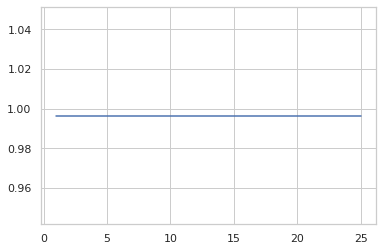

In [43]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='rbf', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(range(1,26), acc_score)
print(acc_score)

[0.9402882205513784, 0.9595864661654134, 0.9701127819548871, 0.9788847117794486, 0.9806390977443608, 0.9806390977443608, 0.9806390977443608, 0.9876879699248121, 0.9876879699248121, 0.9894736842105264, 0.9894736842105264, 0.9912280701754386, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509, 0.9929824561403509]


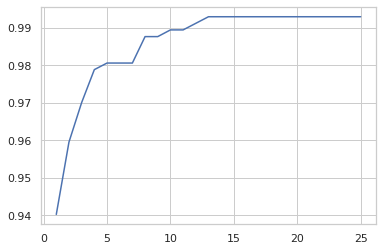

In [44]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='poly', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(range(1,26), acc_score)
print(acc_score)

[0.980670426065163, 0.975407268170426, 0.9736842105263157, 0.9754385964912281, 0.9666040100250626, 0.9666353383458647, 0.9701441102756891, 0.9683897243107771, 0.9683897243107771, 0.9683897243107771, 0.9701441102756891, 0.9683897243107771, 0.9683897243107771, 0.9683897243107771, 0.9666353383458647, 0.9648809523809524, 0.9666353383458647, 0.9683897243107771, 0.9683897243107771, 0.9683897243107771, 0.9683897243107771, 0.9666353383458647, 0.9666353383458647, 0.9666353383458647, 0.9666353383458647]


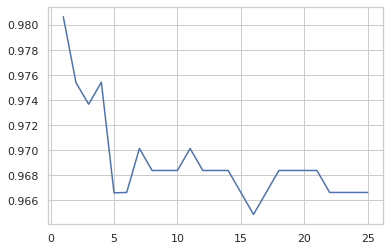

In [45]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='sigmoid', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(range(1,26), acc_score)
print(acc_score)

[0.6432330827067669, 0.7276002506265663, 0.8559210526315789, 0.9402882205513784, 0.9894736842105264]


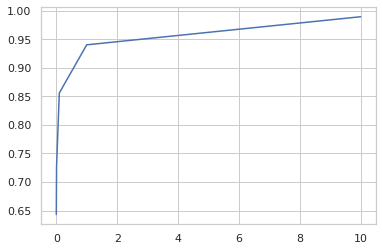

In [46]:
C_range=[0.001, 0.01, 0.1, 1.0, 10]
acc_score=[]
for c in C_range:
    svc = SVC(kernel='poly', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(C_range, acc_score)
print(acc_score)

[0.6274122807017544, 0.7136278195488722, 0.9842105263157895, 0.9964912280701753, 0.9964912280701753]


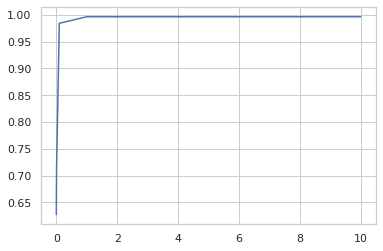

In [47]:
C_range=[0.001, 0.01, 0.1, 1.0, 10]
acc_score=[]
for c in C_range:
    svc = SVC(kernel='rbf', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(C_range, acc_score)
print(acc_score)

[0.6274122807017544, 0.9420112781954886, 0.9929824561403509, 0.980670426065163, 0.9683897243107771]


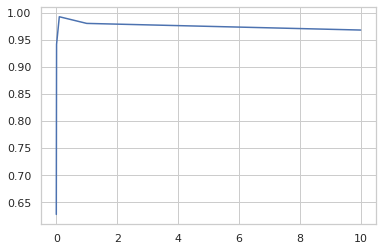

In [48]:
C_range=[0.001, 0.01, 0.1, 1.0, 10]
acc_score=[]
for c in C_range:
    svc = SVC(kernel='sigmoid', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
plt.plot(C_range, acc_score)
print(acc_score)

# Conclusion:
* As we can see that as C value increase the accuracy is increasing respective of the KERNEl
* Since C is the hyperparameter
* As C increase the Overfitting occurs.
* A C decreases the underfitting occures.

In [49]:
svc=SVC(kernel='poly', C=1.0) #Default hyperparameters
svc.fit(X_train,y_train)
y_pred=svc.predict(X_train)

In [50]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred))
print("F1 Score:-", metrics.f1_score(y_train, y_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred))
print("Log Loss:-", metrics.log_loss(y_train, y_pred))
print("Precision Score:-", metrics.precision_score(y_train, y_pred))
print("Recall Score:-", metrics.recall_score(y_train, y_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred))

Accuracy Score:- 0.9340659340659341
F1 Score:- 0.9032258064516129
Average Precision Score:- 0.8894634776987718
Log Loss:- 2.277281960104002
Precision Score:- 1.0
Recall Score:- 0.8235294117647058
ROC-AUC Score:- 0.9117647058823529


In [51]:
y_test_pred=svc.predict(X_test)

In [52]:
svc_acc=metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy Score:-",svc_acc)
print("F1 Score:-", metrics.f1_score(y_test, y_test_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_test, y_test_pred))
print("Log Loss:-", metrics.log_loss(y_test, y_test_pred))
print("Precision Score:-", metrics.precision_score(y_test, y_test_pred))
print("Recall Score:-", metrics.recall_score(y_test, y_test_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy Score:- 0.9298245614035088
F1 Score:- 0.8947368421052632
Average Precision Score:- 0.8796992481203008
Log Loss:- 2.423773782098996
Precision Score:- 1.0
Recall Score:- 0.8095238095238095
ROC-AUC Score:- 0.9047619047619048


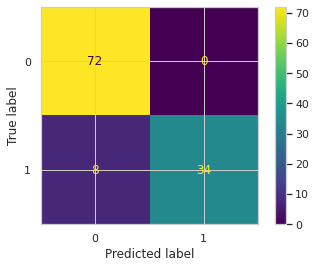

In [53]:
cfm=confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=svc.classes_)
disp.plot()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        72
           1       1.00      0.81      0.89        42

    accuracy                           0.93       114
   macro avg       0.95      0.90      0.92       114
weighted avg       0.94      0.93      0.93       114



In [55]:
y_test_pred_prob=lr.predict_proba(X_test)[:,1]
y_test_pred_prob

from sklearn.metrics import roc_curve
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.6266534391534392

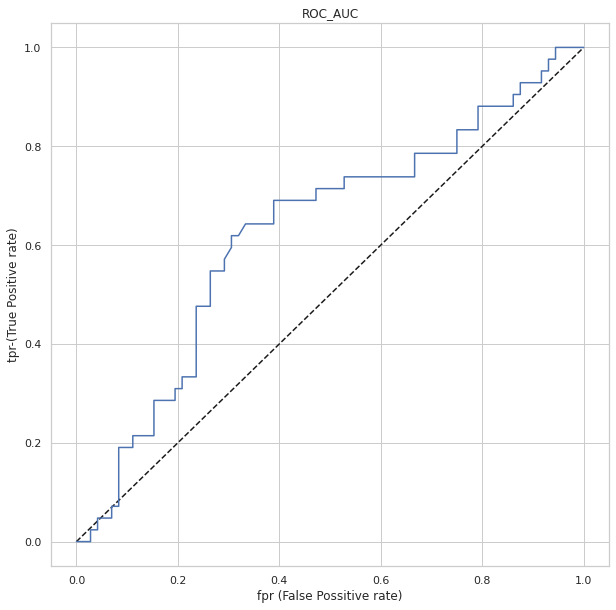

In [56]:
fpr, tpr,thresholds=roc_curve(y_test,y_test_pred_prob)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
plt.title("ROC_AUC")
plt.show()

# Decision Tree Clasifiers

In [57]:
from sklearn.tree import DecisionTreeClassifier


In [58]:
X=df.drop(col, axis=1)
y=df['diagnosis']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=10)

In [59]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [60]:
y_pred_gini = clf_gini.predict(X_train)

In [61]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred_gini))
print("F1 Score:-", metrics.f1_score(y_train, y_pred_gini))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred_gini))
print("Log Loss:-", metrics.log_loss(y_train, y_pred_gini))
print("Precision Score:-", metrics.precision_score(y_train, y_pred_gini))
print("Recall Score:-", metrics.recall_score(y_train, y_pred_gini))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred_gini))

Accuracy Score:- 1.0
F1 Score:- 1.0
Average Precision Score:- 1.0
Log Loss:- 9.992007221626413e-16
Precision Score:- 1.0
Recall Score:- 1.0
ROC-AUC Score:- 1.0


In [62]:
y_test_pred= clf_gini.predict(X_test)

In [63]:
dc_acc=metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy Score:-",dc_acc)
print("F1 Score:-", metrics.f1_score(y_test, y_test_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_test, y_test_pred))
print("Log Loss:-", metrics.log_loss(y_test, y_test_pred))
print("Precision Score:-", metrics.precision_score(y_test, y_test_pred))
print("Recall Score:-", metrics.recall_score(y_test, y_test_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy Score:- 1.0
F1 Score:- 1.0
Average Precision Score:- 1.0
Log Loss:- 9.992007221626413e-16
Precision Score:- 1.0
Recall Score:- 1.0
ROC-AUC Score:- 1.0


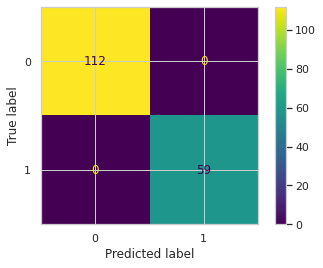

In [64]:
cfm=confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=clf_gini.classes_)
disp.plot()

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        59

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



In [66]:
y_test_pred_prob=clf_gini.predict_proba(X_test)[:,1]
y_test_pred_prob

from sklearn.metrics import roc_curve
metrics.roc_auc_score(y_test, y_test_pred_prob)

1.0

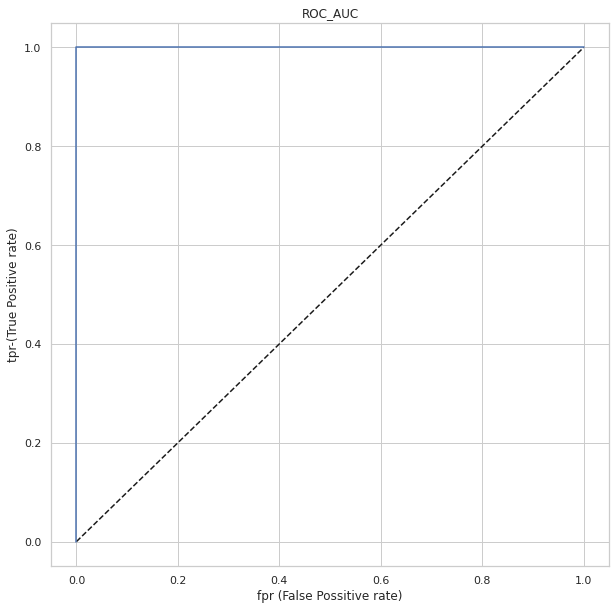

In [67]:
fpr, tpr,thresholds=roc_curve(y_test,y_test_pred_prob)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
plt.title("ROC_AUC")
plt.show()

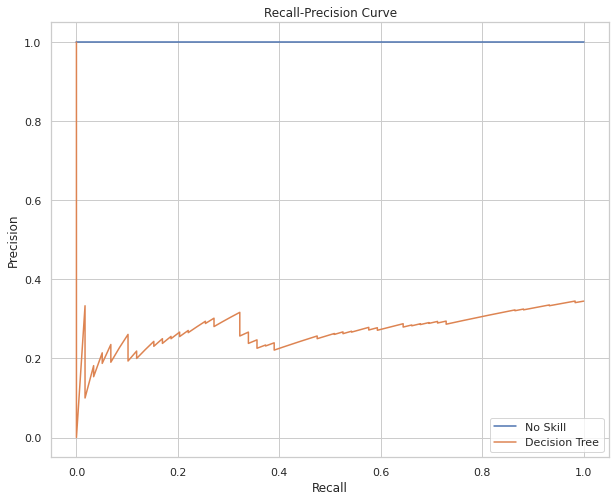

In [68]:
from sklearn.metrics import precision_recall_curve
no_skill=len(y==1)/len(y)
y_test_prob=lr.predict_proba(X_test)[:,1]
plt.figure(figsize=(10,8))
plt.plot([0,1],[no_skill, no_skill], label="No Skill")
precision, recall,_ =precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='',label="Decision Tree")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision Curve")
plt.legend()
plt.show()

In [69]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


# Visualize decision-trees

[Text(334.8, 326.15999999999997, 'X[1] <= 0.5\ngini = 0.473\nsamples = 398\nvalue = [245, 153]'),
 Text(167.4, 108.72000000000003, 'gini = 0.0\nsamples = 245\nvalue = [245, 0]'),
 Text(502.20000000000005, 108.72000000000003, 'gini = 0.0\nsamples = 153\nvalue = [0, 153]')]

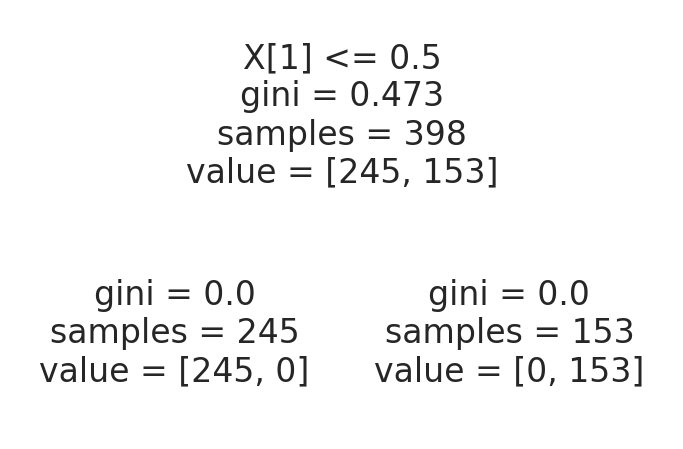

In [70]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train)) 

# Decision Tree Classifier with criterion entropy¶

In [71]:
clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

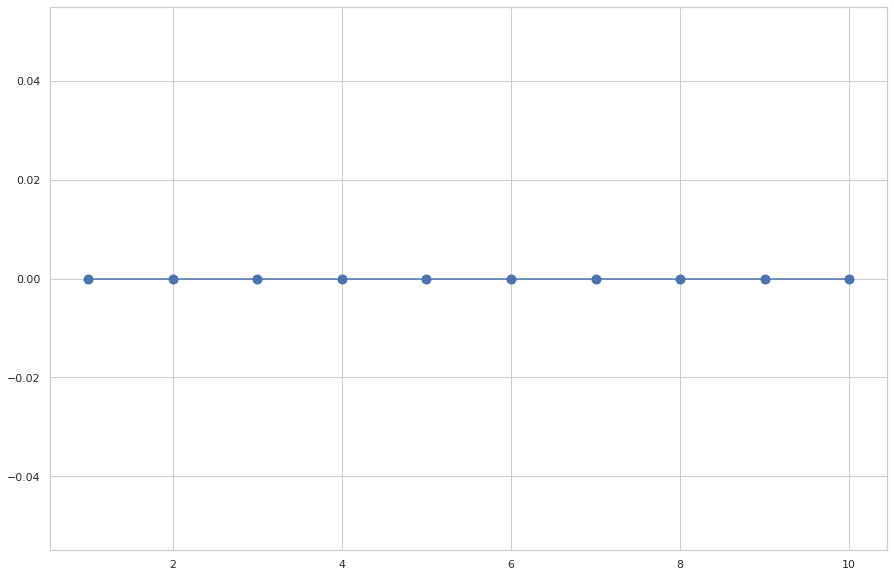

In [72]:
error_rate=[]
for i in range(1,11):
    clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


    # fit the model
    clf_en.fit(X_train, y_train)
    pred=clf_en.predict(X_test)
    error_rate.append(np.mean(pred!=y_test))
    
plt.figure(figsize=(15,10))
plt.plot(range(1,11), error_rate,marker='o', markersize=9)
    

In [73]:
clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [74]:
y_pred=clf_en.predict(X_train)

In [75]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred))
print("F1 Score:-", metrics.f1_score(y_train, y_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred))
print("Log Loss:-", metrics.log_loss(y_train, y_pred))
print("Precision Score:-", metrics.precision_score(y_train, y_pred))
print("Recall Score:-", metrics.recall_score(y_train, y_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred))

Accuracy Score:- 1.0
F1 Score:- 1.0
Average Precision Score:- 1.0
Log Loss:- 9.992007221626413e-16
Precision Score:- 1.0
Recall Score:- 1.0
ROC-AUC Score:- 1.0


In [76]:
y_test_pred=clf_en.predict(X_test)


In [77]:
dc_en_acc=metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy Score:-",dc_en_acc)
print("F1 Score:-", metrics.f1_score(y_test, y_test_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_test, y_test_pred))
print("Log Loss:-", metrics.log_loss(y_test, y_test_pred))
print("Precision Score:-", metrics.precision_score(y_test, y_test_pred))
print("Recall Score:-", metrics.recall_score(y_test, y_test_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy Score:- 1.0
F1 Score:- 1.0
Average Precision Score:- 1.0
Log Loss:- 9.992007221626413e-16
Precision Score:- 1.0
Recall Score:- 1.0
ROC-AUC Score:- 1.0


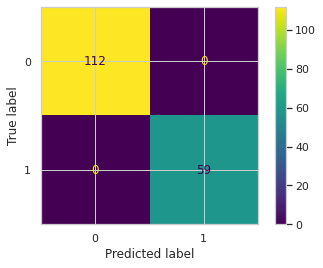

In [78]:
cfm=confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=clf_en.classes_)
disp.plot()

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        59

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



In [80]:
y_test_pred_prob=clf_gini.predict_proba(X_test)[:,1]
y_test_pred_prob

from sklearn.metrics import roc_curve
metrics.roc_auc_score(y_test, y_test_pred_prob)

1.0

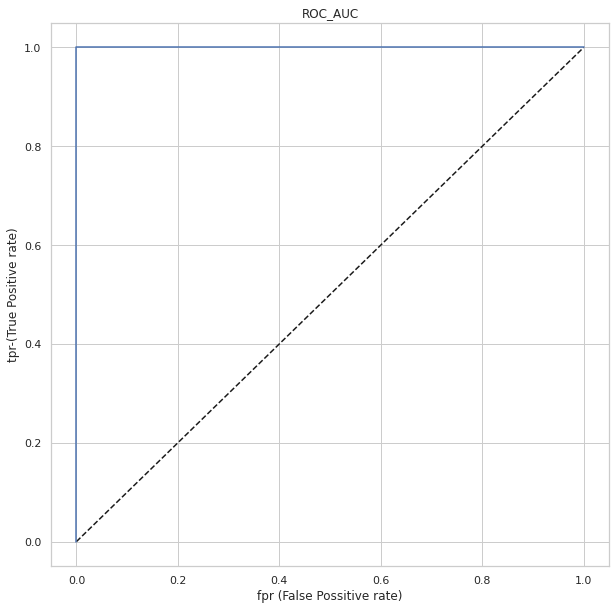

In [81]:
fpr, tpr,thresholds=roc_curve(y_test,y_test_pred_prob)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='DEcision Tree with Entropy')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
plt.title("ROC_AUC")
plt.show()

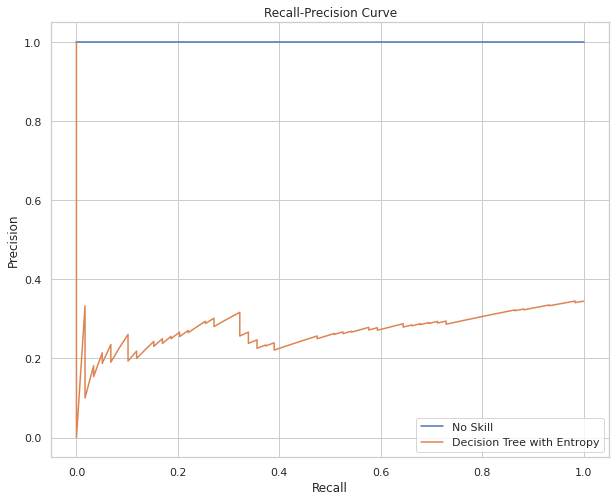

In [82]:
from sklearn.metrics import precision_recall_curve
no_skill=len(y==1)/len(y)
y_test_prob=lr.predict_proba(X_test)[:,1]
plt.figure(figsize=(10,8))
plt.plot([0,1],[no_skill, no_skill], label="No Skill")
precision, recall,_ =precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='',label="Decision Tree with Entropy")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision Curve")
plt.legend()
plt.show()

# Random Forest Classifiers

In [83]:
# split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [84]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier



# instantiate the classifier 

rfc = RandomForestClassifier(random_state=0)



# fit the model

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [85]:
y_pred = rfc.predict(X_train)


In [86]:
print("Accuracy Score:-", metrics.accuracy_score(y_train, y_pred))
print("F1 Score:-", metrics.f1_score(y_train, y_pred))
print("Average Precision Score:-", metrics.average_precision_score(y_train, y_pred))
print("Log Loss:-", metrics.log_loss(y_train, y_pred))
print("Precision Score:-", metrics.precision_score(y_train, y_pred))
print("Recall Score:-", metrics.recall_score(y_train, y_pred))
print("ROC-AUC Score:-", metrics.roc_auc_score(y_train, y_pred))

Accuracy Score:- 1.0
F1 Score:- 1.0
Average Precision Score:- 1.0
Log Loss:- 9.992007221626413e-16
Precision Score:- 1.0
Recall Score:- 1.0
ROC-AUC Score:- 1.0


# Conclusion 
* These are overfit model
* We need more features to remove

# What we can do ??
we have two options
* remove the feature which have correlation more than 0.9
* Another one is backward stepwise

Next, we compare the correlation between features and remove one of two features that have a correlation higher than 0.9

In [87]:
corr=df.corr()

In [88]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
df = df[selected_columns]

* Now, the dataset has only those columns with correlation less than 0.9
* Next we will be selecting the columns based on how they affect the p-value. We are the removing the column diagnosis because it is the column we are trying to predict

In [89]:
selected_columns = selected_columns[1:].to_numpy()
# importing the statsmodels
import statsmodels.api as sm

# defing the backward elimination

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(df.iloc[:,1:].values, df.iloc[:,0].values, SL, selected_columns)